In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import warnings
warnings.filterwarnings('ignore')

In [34]:
def _load_shape(filename = 'netsuke100k', root = '../autodl-tmp/pclouds'):
    point_file = os.path.join(root, filename+'.xyz')
    normals_file = os.path.join(root, filename+'.normals')
    curv_file = os.path.join(root, filename+'.curv')
    pidx_file = os.path.join(root, filename+'.pidx')
    pts = np.loadtxt(point_file).astype('float32')
    normals = np.loadtxt(normals_file).astype('float32')
    curv = np.loadtxt(curv_file).astype('float32')
    pidx = np.loadtxt(pidx_file).astype('int')
    return pts, normals, curv, pidx
pts, normals, curv, pidx = _load_shape()
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)
def normal2rgb(normals):
    '''
    converts the normal vector to RGB color values
    :param normals: nx3 normal vecors
    :return: rgb - Nx3 color value for each normal vector in uint8
    '''
    if normals.shape[1] != 3:
        raise ValueError('normal vector should be n by 3 array')

    normals = np.divide(normals,np.tile(np.expand_dims(np.sqrt(np.sum(np.square(normals), axis=1)),
                                                       axis= 1),[1, 3]))  # make sure normals are normalized

    rgb = 127.5 + 127.5 * normals
    return rgb/255.0

In [4]:
pred_normal = np.loadtxt('../pcpnet/visualresults/single_scale_normal_curv/galera100k.normals').astype('float32')
pred_curv = np.loadtxt('../pcpnet/visualresults/single_scale_normal_curv/galera100k.curv').astype('float32')
print(pred_normal.shape)

(100000, 3)


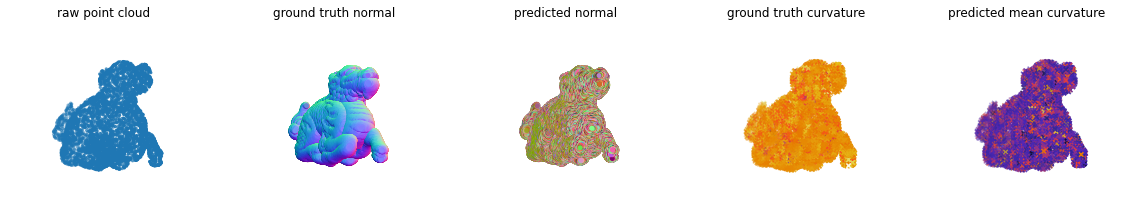

0

In [66]:
def visual_results(fig, points, normals, curv, pidx, pred_normal, pred_curv, i = 1, length = 1, output_filename='default_output_name', display=False, ax='none', color='CMRmap', vmin=0, vmax=1):
    """ points is a Nx3 numpy array """
    point_range = pidx
    mean_curv = curv.mean(1)
    mean_pred_curv = pred_curv.mean(1)
    if fig == 'none':
        fig = plt.figure(figsize= (20,4))
    ax1 = fig.add_subplot(length, 5, i, projection='3d')
    i+=1
    ax1.scatter(points[point_range, 0], points[point_range, 1], points[point_range, 2], marker='.', cmap=color)
    ax1.view_init(elev=90, azim=-90 )
    ax1.axis('off')
    ax1.set_title('raw point cloud')
    
    overlay1 = normal2rgb(normals)
    ax2 = fig.add_subplot(length,5, i, projection='3d')
    i+=1
    ax2.scatter(points[:, 0], points[:, 1], points[:, 2], c=overlay1, s=100, marker='.', edgecolors='none')
    axisEqual3D(ax2)
    ax2.view_init(elev=90, azim=-90 )
    ax2.axis('off')
    ax2.set_title('ground truth normal')
    
    overlay2 = normal2rgb(pred_normal)
    ax3 = fig.add_subplot(length, 5, i, projection='3d')
    i+=1
    ax3.scatter(points[:, 0], points[:, 1], points[:, 2], c=overlay2, s=100, marker='.', edgecolors='none')
    axisEqual3D(ax3)
    ax3.view_init(elev=90, azim=-90 )
    ax3.axis('off')
    ax3.set_title('predicted normal')
    
    ax4 = fig.add_subplot(length,5, i,projection = '3d')
    i+=1
    ax4.scatter(points[point_range,0], 
                points[point_range,1], 
                points[point_range,2], 
                c = mean_curv[point_range],
                cmap = 'CMRmap',
                marker= 'x')
    ax4.view_init(elev=90, azim=-90 )
    ax4.axis('off')
    ax4.set_title('ground truth curvature')
    
    ax5 = fig.add_subplot(length,5,i,projection = '3d')
    ax5.scatter(points[point_range,0], 
                points[point_range,1], 
                points[point_range,2], 
                c = mean_pred_curv[point_range],
                cmap = 'CMRmap',
                marker= 'x')
    ax5.view_init(elev=90, azim=-90 )
    ax5.axis('off')
    ax5.set_title('predicted mean curvature')
    if display:
        plt.show()
    
    return 0
visual_results('none',pts, normals, curv, pidx, pred_normal, pred_curv, display = True)

In [67]:
def visual_exp(visual_set = '../autodl-tmp/pclouds/visualset_no_noise.txt', save_path = './', result_path = './visualresults/single_scale_normal_curv'):
    with open(visual_set, 'r') as f:
        shape_list = f.readlines()
    shape_list = [x.strip() for x in shape_list]
    shape_list = list(filter(None, shape_list))
    length = len(shape_list)
    fig = plt.figure(figsize = (20, length*4))
    for i, shape in enumerate(shape_list):
        pts, normals, curv, pidx = _load_shape(shape)
        pred_normal_filename = os.path.join(result_path, shape+'.normals')
        pred_curv_filename = os.path.join(result_path, shape+'.curv')
        print(pred_normal_filename, pred_curv_filename)
        pred_normal = np.loadtxt(pred_normal_filename).astype('float32')
        pred_curv = np.loadtxt(pred_curv_filename).astype('float32')
        visual_results(fig = fig, 
                       points = pts, 
                       normals = normals, 
                       curv = curv, 
                       pidx = pidx,
                       pred_normal = pred_normal, 
                       pred_curv = pred_curv, 
                       i = i*length+1, 
                       length = length,
                       display=False, color='CMRmap', vmin=0, vmax=1)
    plt.savefig(os.path.join(save_path, 'exp.png'))
    plt.show()
    return 0

./visualresults/single_scale_normal_curv/Cup34100k.normals ./visualresults/single_scale_normal_curv/Cup34100k.curv
./visualresults/single_scale_normal_curv/Liberty100k.normals ./visualresults/single_scale_normal_curv/Liberty100k.curv
./visualresults/single_scale_normal_curv/star_sharp100k.normals ./visualresults/single_scale_normal_curv/star_sharp100k.curv
./visualresults/single_scale_normal_curv/netsuke100k.normals ./visualresults/single_scale_normal_curv/netsuke100k.curv
./visualresults/single_scale_normal_curv/cylinder_analytic100k.normals ./visualresults/single_scale_normal_curv/cylinder_analytic100k.curv


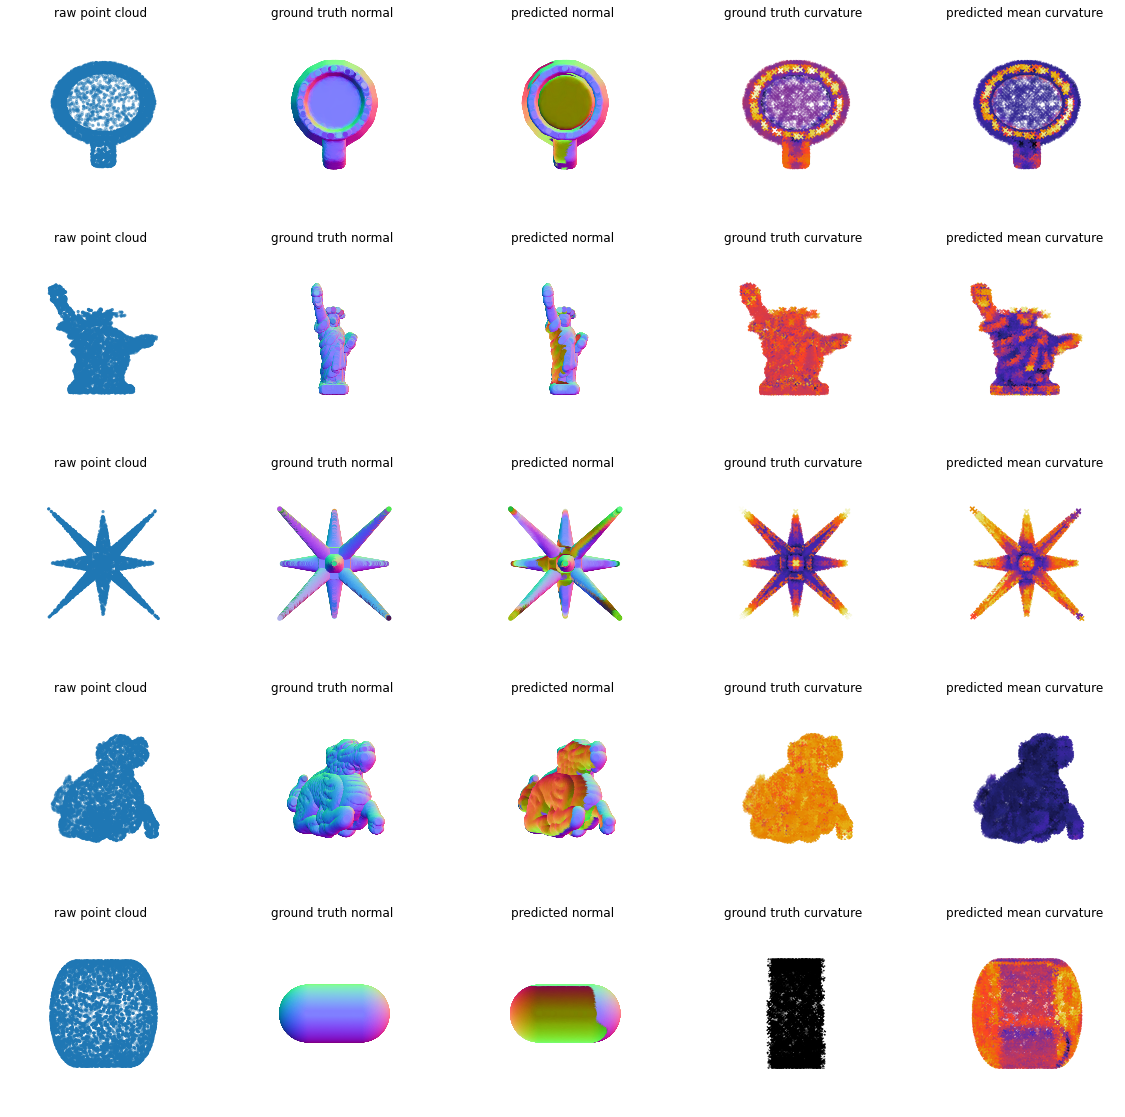

0

In [68]:
visual_exp()